# Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import re
from nltk.tokenize import sent_tokenize, word_tokenize

from math import ceil

In [4]:
from tqdm import tqdm

In [5]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [6]:
def buildWordCloud(i, text, w=1200, h=1000, mw=5000):
    wordcloud = WordCloud(width = w, height = h,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10,
                max_words = mw).generate(text)
    plt.figure(figsize = (w//100, h//100), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(f'Most Frequent Words in cluster {i}')
    plt.show()

# Data

In [7]:
text = pd.read_csv('InshortsScraped.csv')['news']

In [8]:
text.head()

0    7 IITs among India's top higher education inst...
1    They forget she's 14: Devgn on trolls criticis...
2    Haven't earned so much that I can wear new clo...
3    Fans in US sing Desi Girl for Priyanka outside...
4    Dhoni bhai was very angry, he hugged me after ...
Name: news, dtype: object

In [9]:
text.shape

(11426,)

# EDA

In [10]:
with open('stopwords.txt') as f:
    stopwords_ = f.readlines()

In [11]:
stopwords = set(map(lambda x: x.strip(), stopwords_))|set(['.'])

In [12]:
print(sorted(stopwords))

['.', 'a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'ain', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'aren', "aren't", 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'computer', 'con', 'could', 'couldn', "couldn't", 'couldnt', 'cry', 'd', 'de', 'describe', 'detail', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fify'

In [13]:
def remove_stop_words(X):
    features = []
    for x in X.split():
        if x.lower() not in stopwords and len(x) > 2:
            features.append(x.lower())
    return ' '.join(features)

In [14]:
text = text.apply(lambda x : re.sub(r'\W', ' ', str(x)))
text = text.apply(lambda x : re.sub(r'\d', ' ', str(x)))
text = text.apply(lambda x : re.sub(r'\.', ' . ', str(x)))
text = text.apply(lambda x : re.sub(r'\s+', ' ', str(x)))
text = text.apply(lambda x : x.strip())
text = text.apply(remove_stop_words)

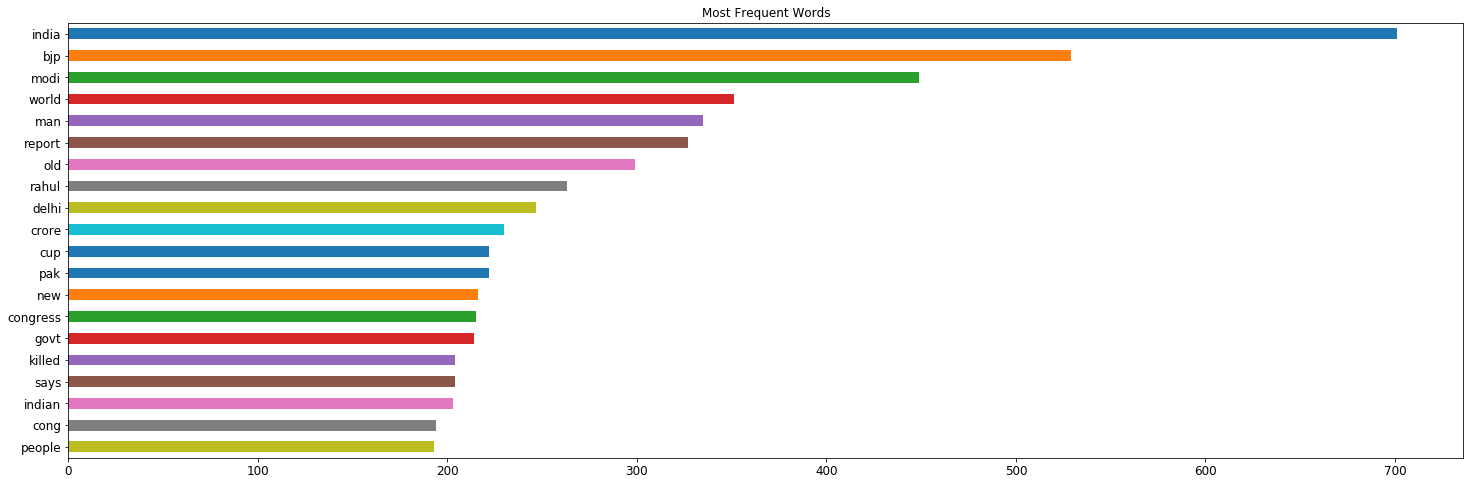

In [15]:
fig, ax = plt.subplots(figsize=(25,8))
pd.Series(' '.join(text).split()).value_counts()[:20].plot.barh(ax = ax, fontsize=12)
ax.set_title(f'Most Frequent Words')
fig.gca().invert_yaxis()


# Vectorization

In [16]:
from gensim.models import Word2Vec

In [17]:
doc = text.apply(lambda x : str(x).split())
w2vmodel = Word2Vec(doc.tolist(), size=128, window=min(5, doc.apply(len).median()//2), min_count=1)

In [18]:
word_list = list(w2vmodel.wv.vocab.keys())

In [19]:
vectors = []
for w in tqdm(word_list):
    vectors.append(w2vmodel.wv[w])

100%|████████████████████████████████████████████████████████████████████████| 13297/13297 [00:00<00:00, 222209.36it/s]


# Clustering

## K Means

In [20]:
from sklearn.cluster import KMeans

Clustering Done !!!


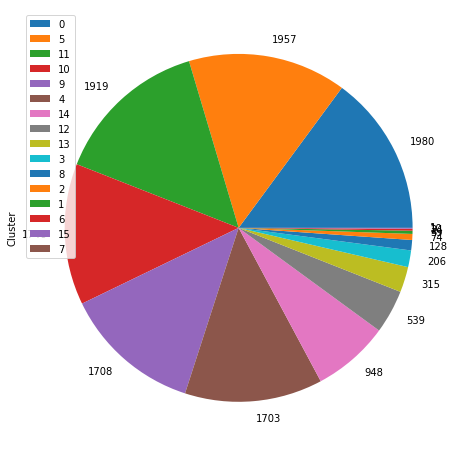

In [21]:
n = 16
model = KMeans(n_clusters=n)
model.fit(vectors)
print('Clustering Done !!!')
y_pred = pd.Series(model.predict(vectors), name='Cluster')
vals = y_pred.value_counts()
vals.plot.pie(figsize=(8, 8), labels=vals)
plt.legend(vals.index)

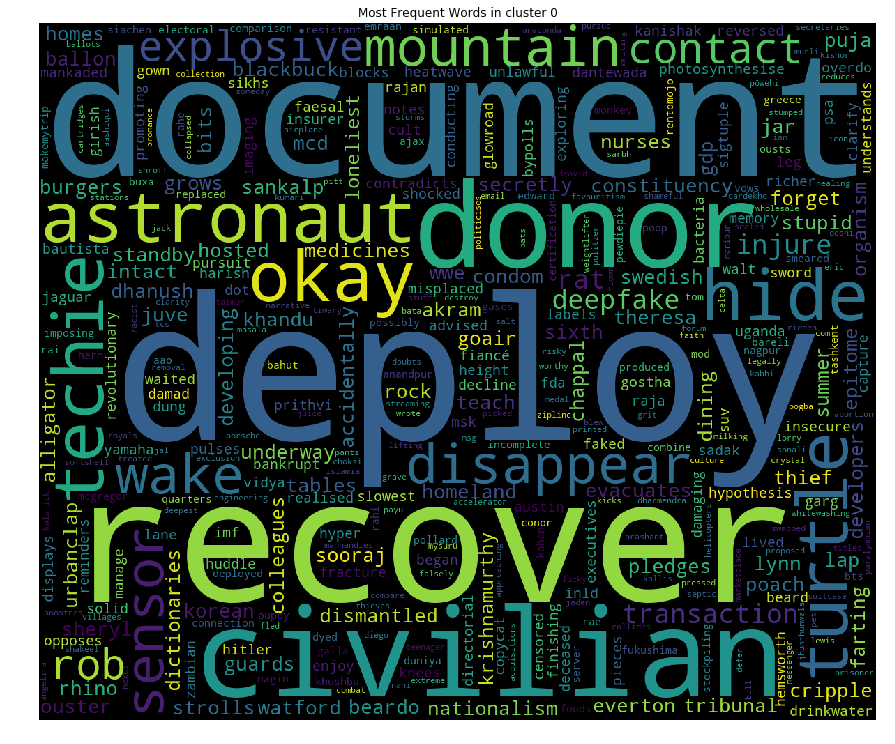

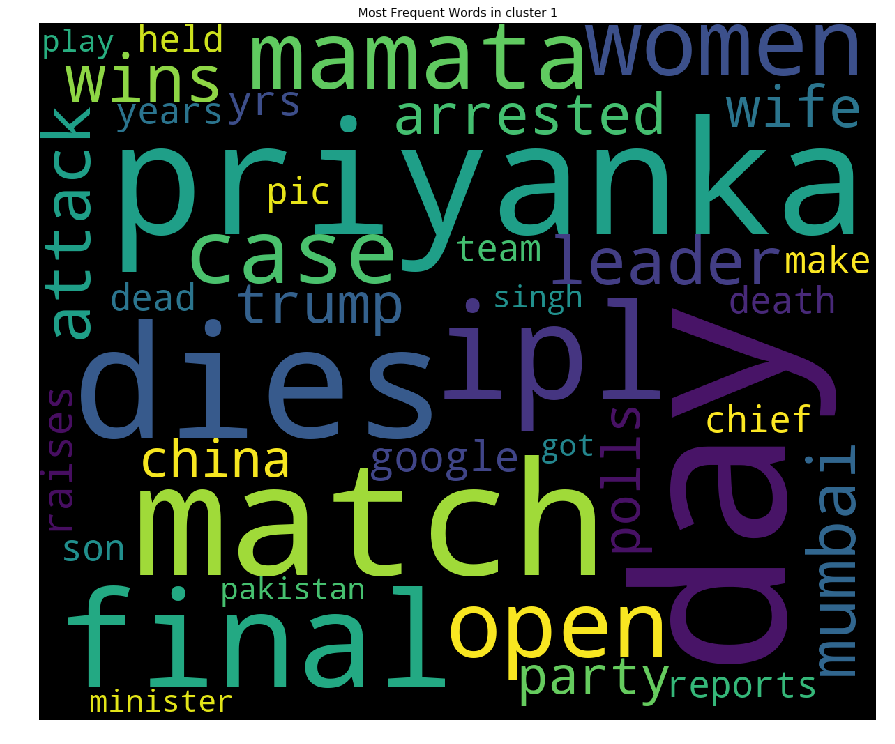

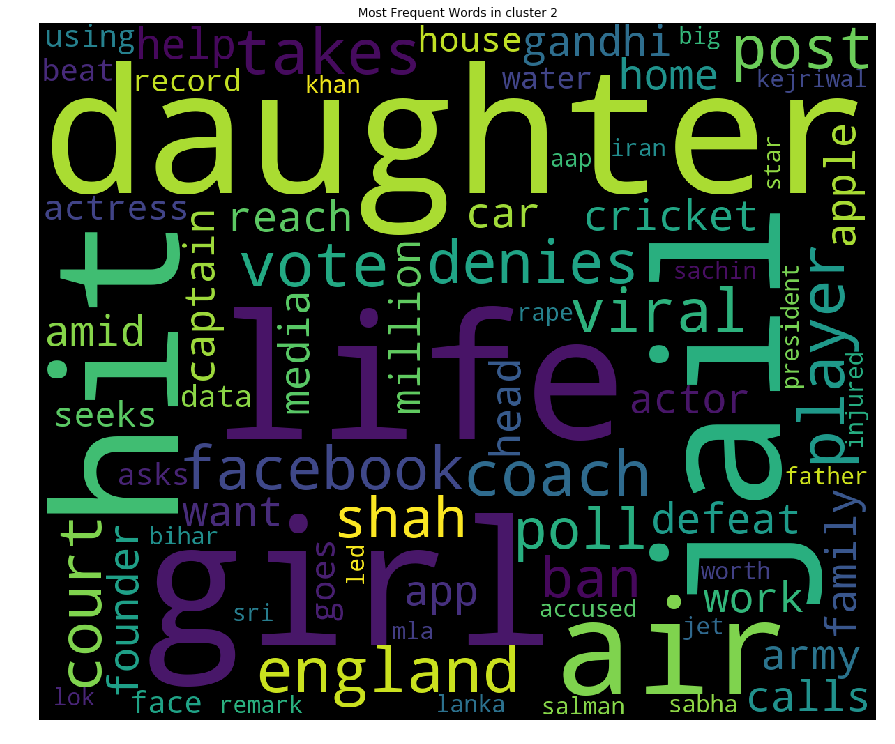

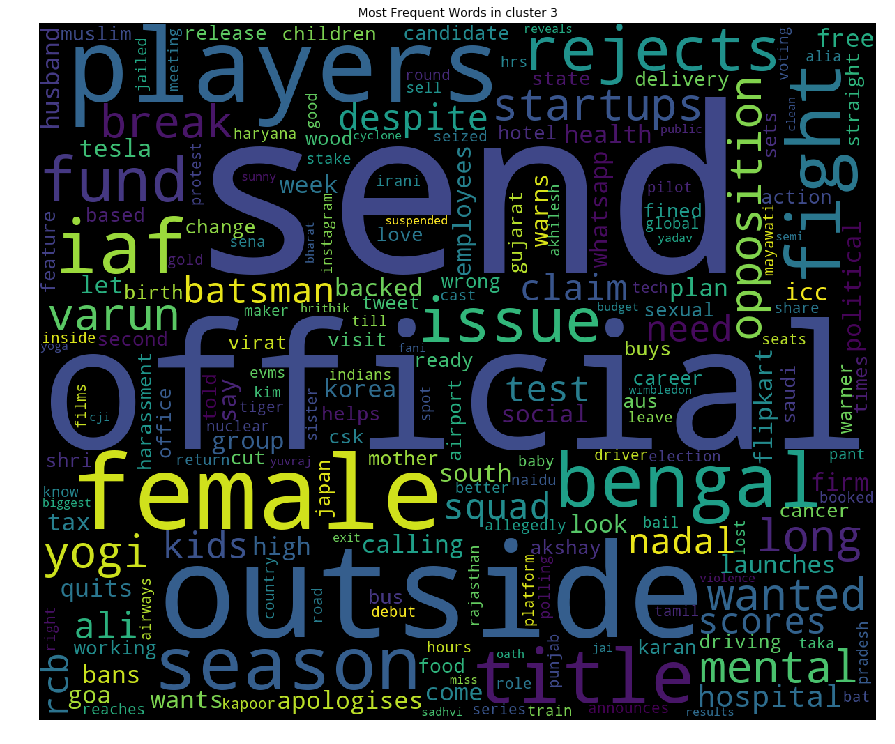

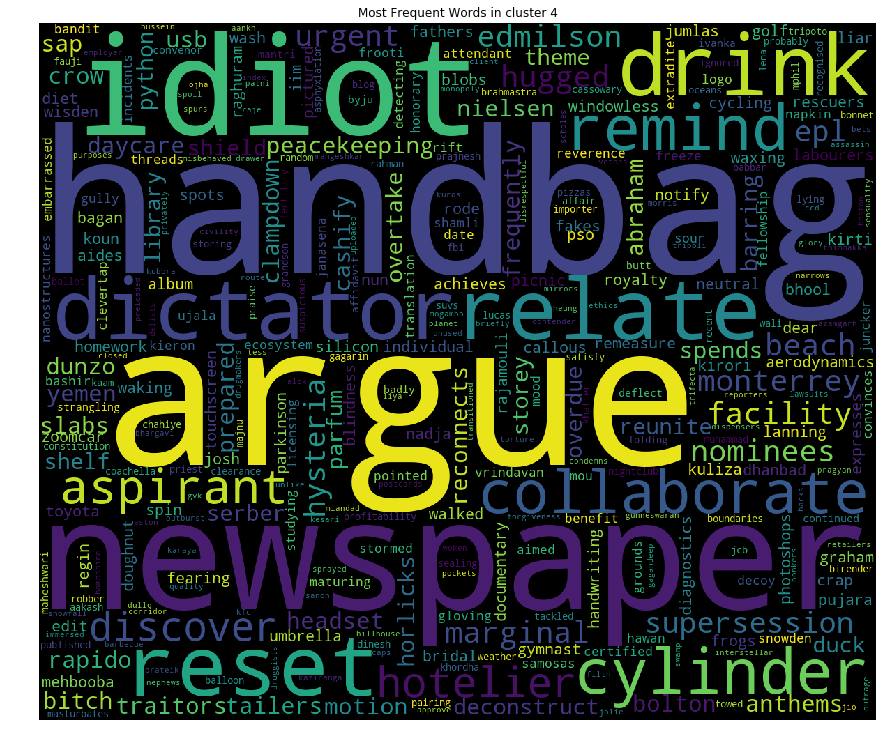

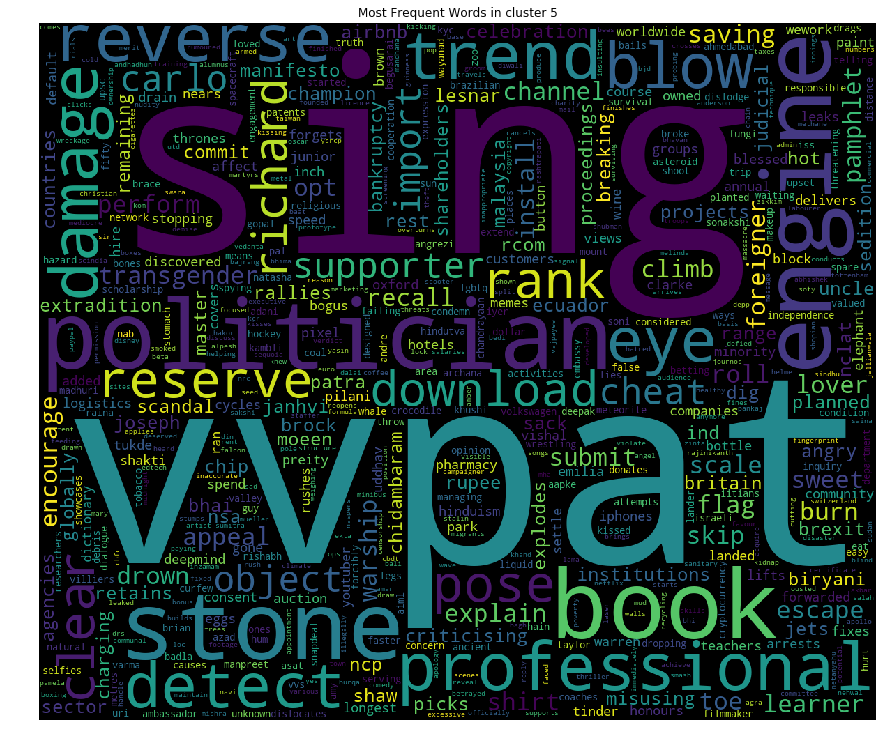

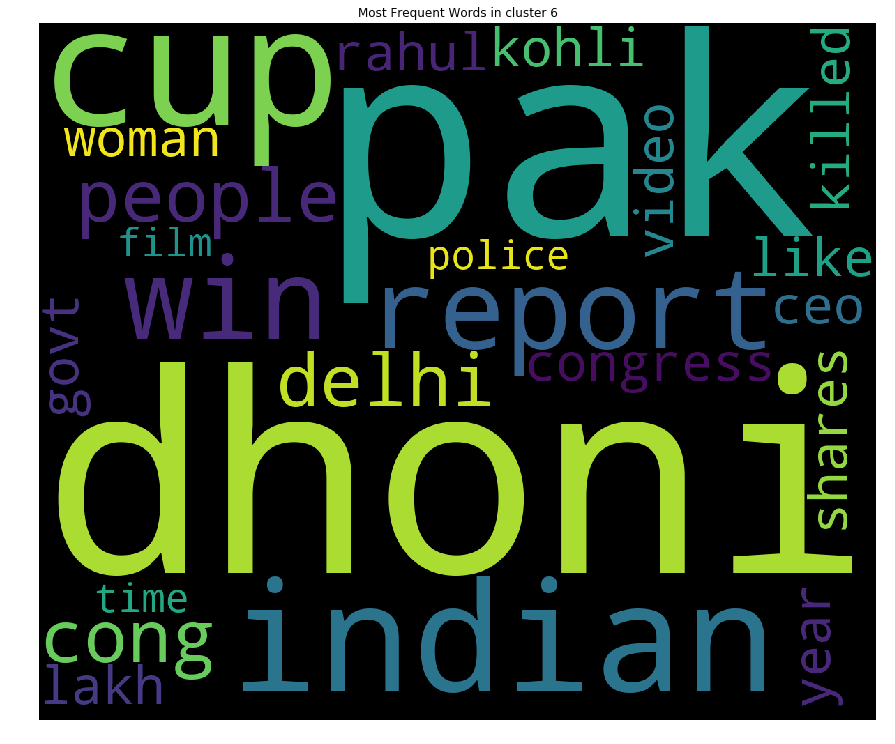

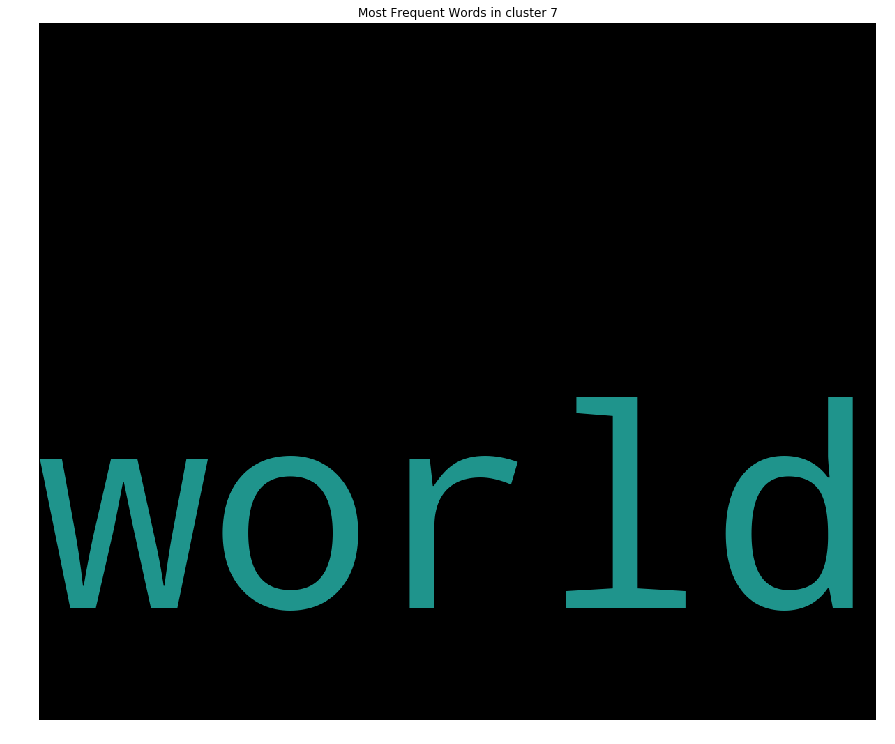

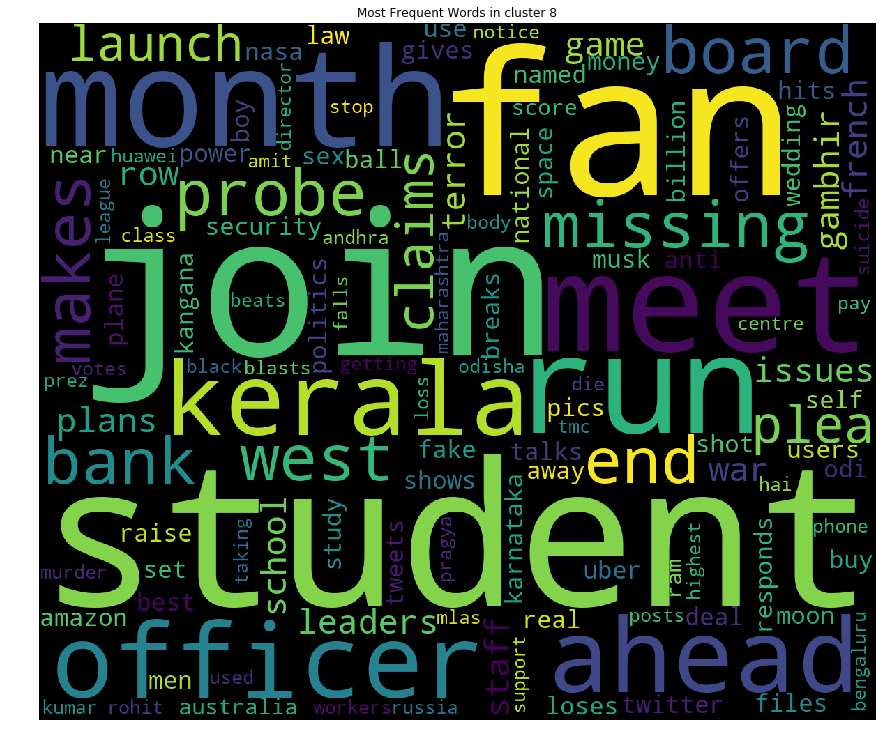

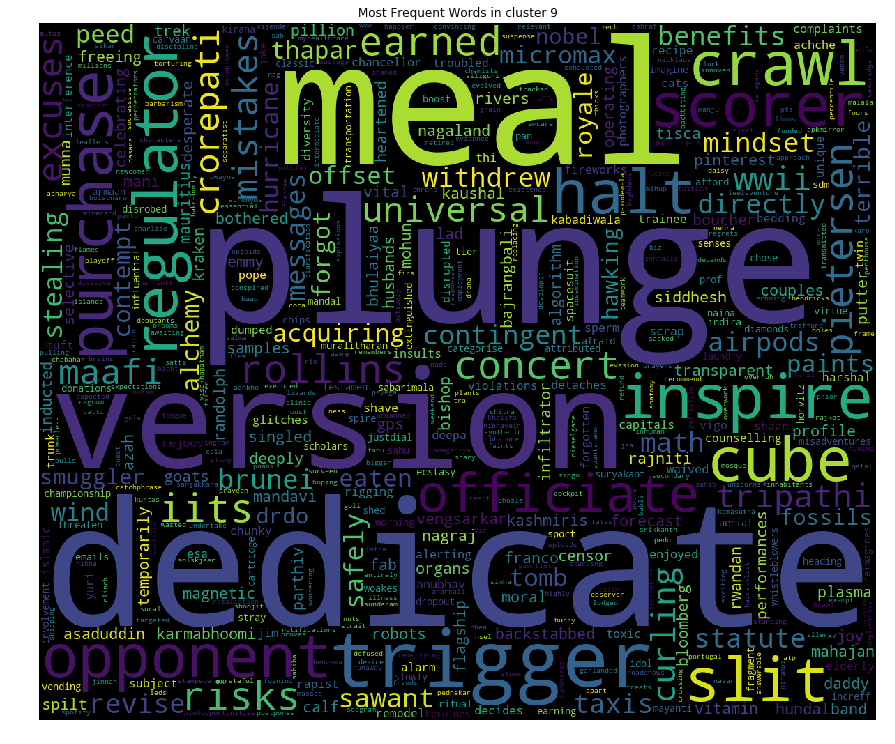

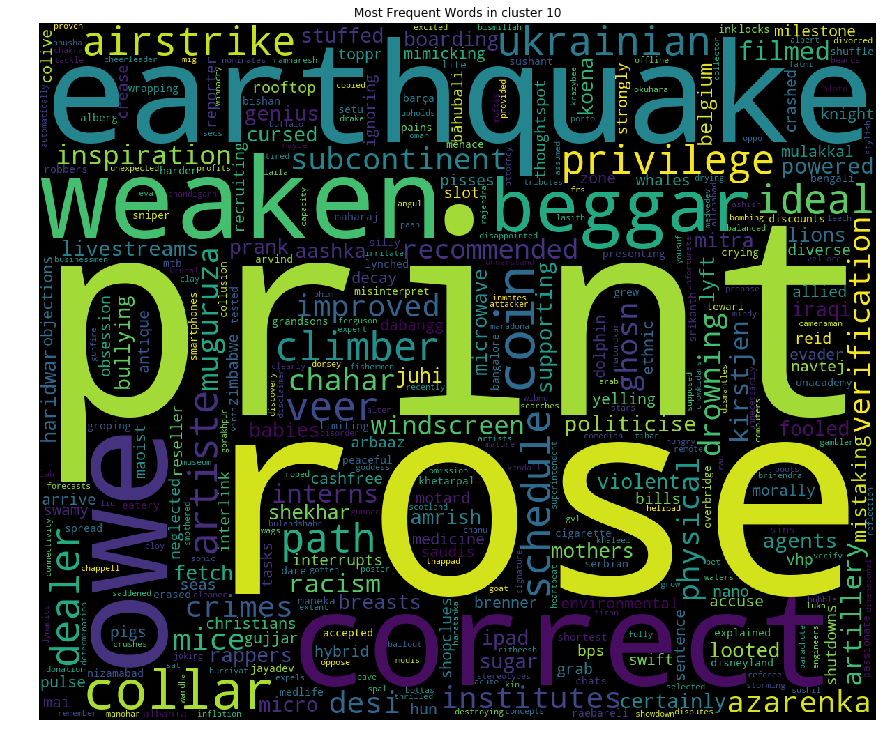

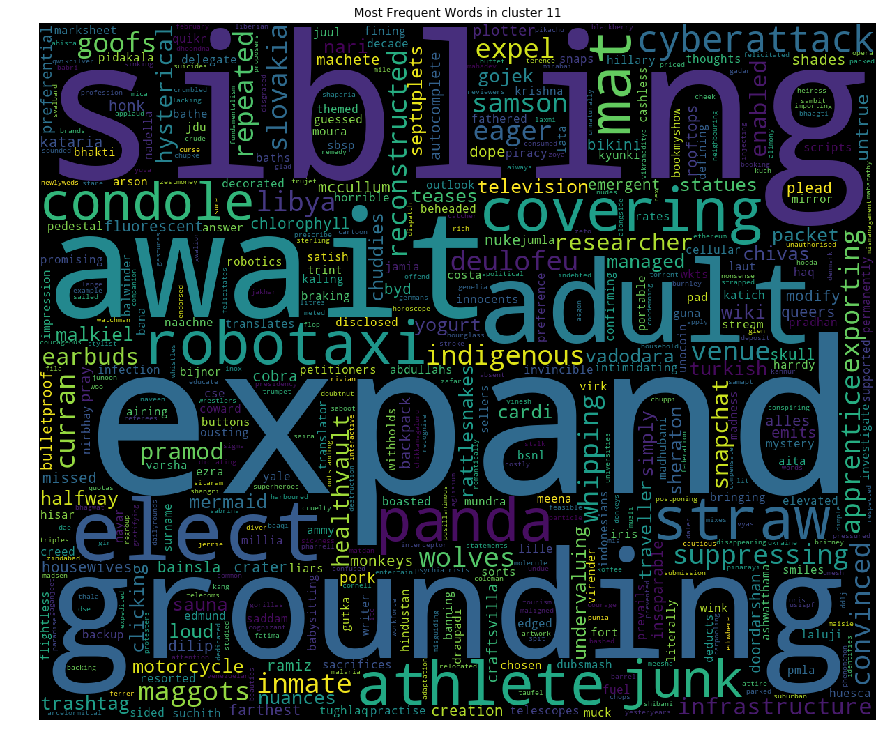

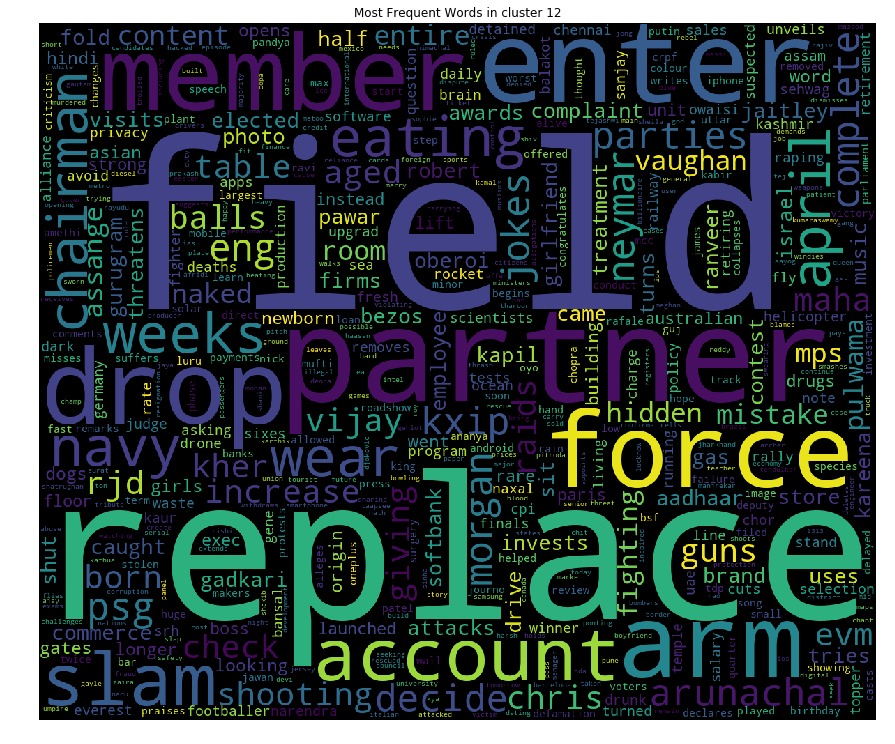

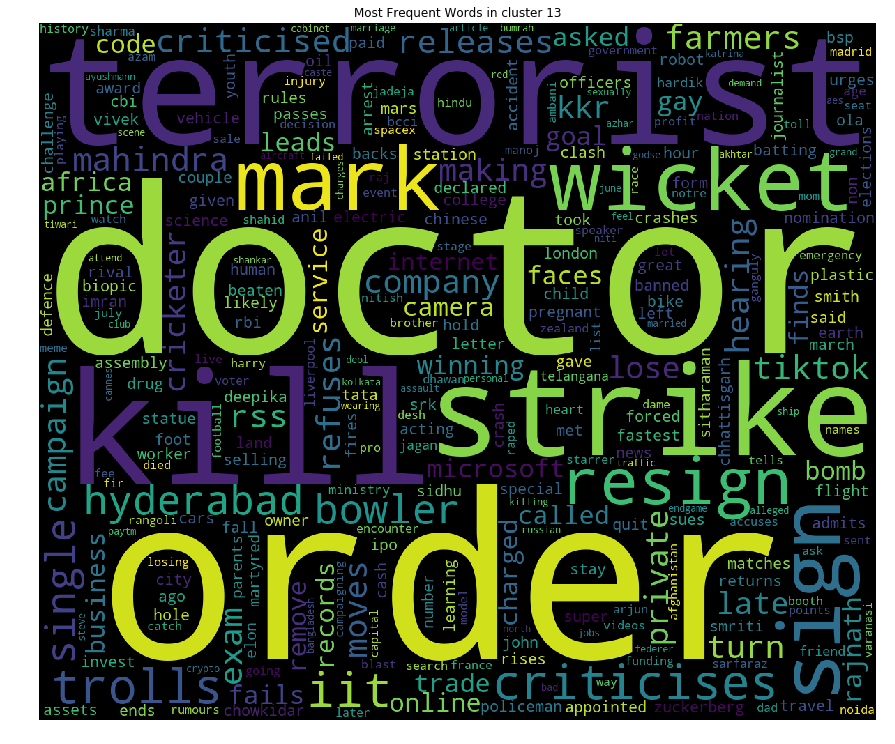

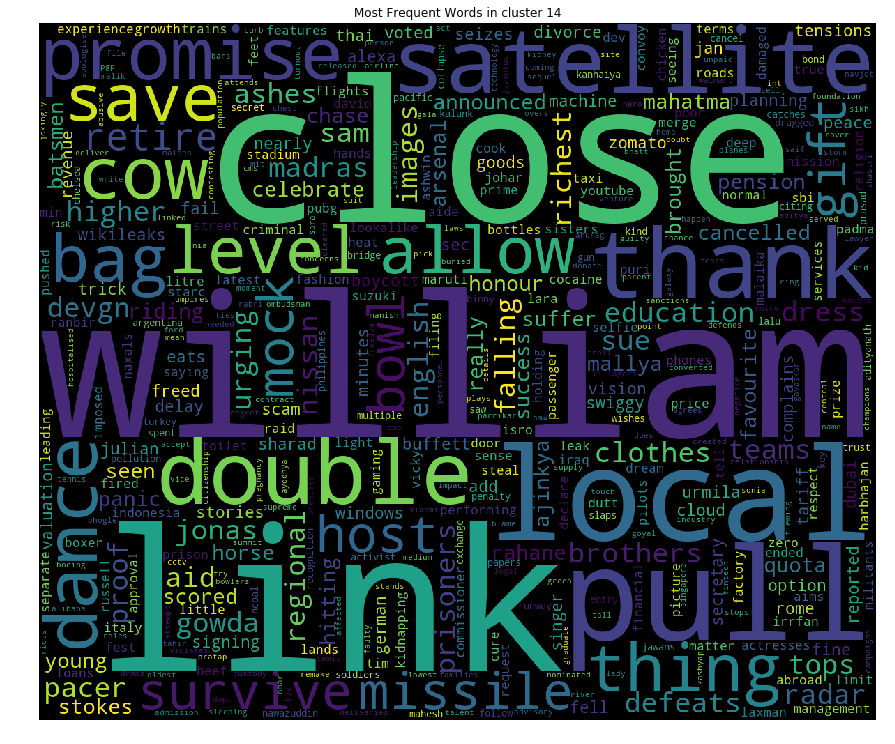

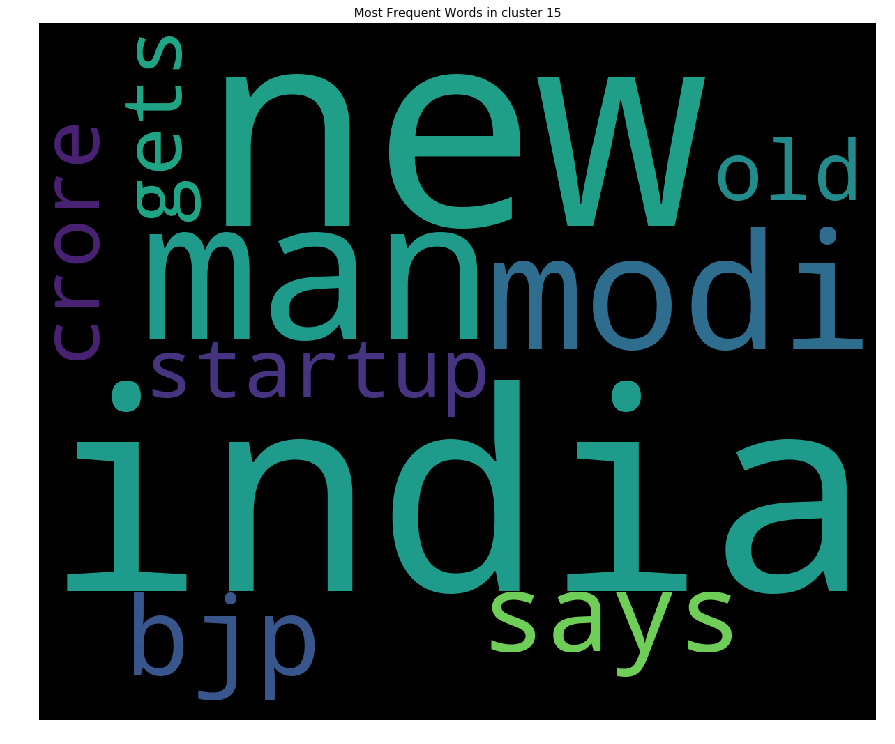

In [22]:
for i in range(n):
    arr = []
    for j, w in enumerate(word_list):
        if y_pred[j] == i:
            arr.append(w)
    buildWordCloud(i, ' '.join(arr))

## Hierarchical

In [23]:
import scipy.cluster.hierarchy as shc

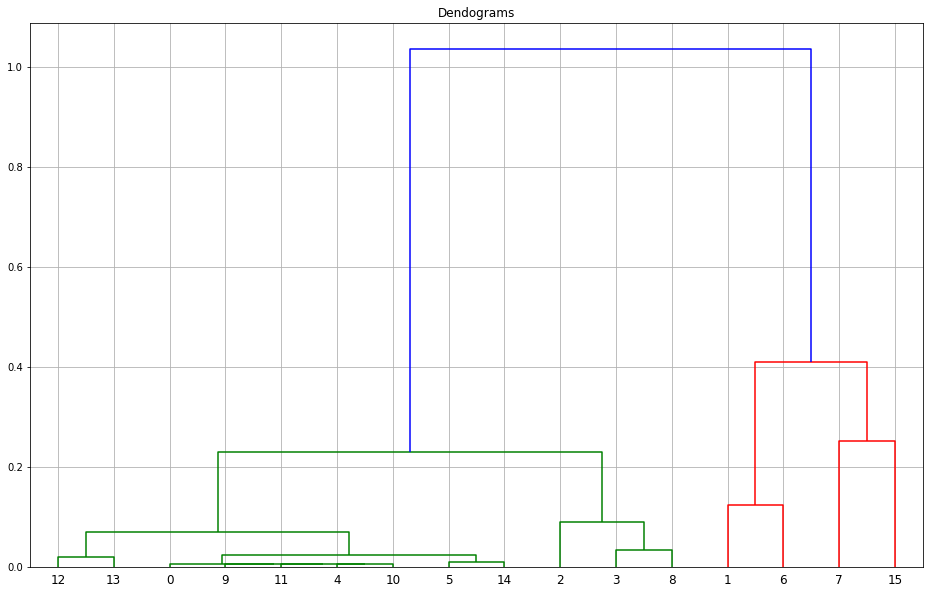

In [24]:
plt.figure(figsize=(16,10))
plt.title("Dendograms")
plt.grid(True)
Z = shc.linkage(model.cluster_centers_, method='ward')
dend = shc.dendrogram(Z)
plt.show()

In [25]:
split = 0.4
h_clusters = shc.fcluster(Z, split, criterion='distance')

In [26]:
y_pred = y_pred.apply(lambda x: h_clusters[x])

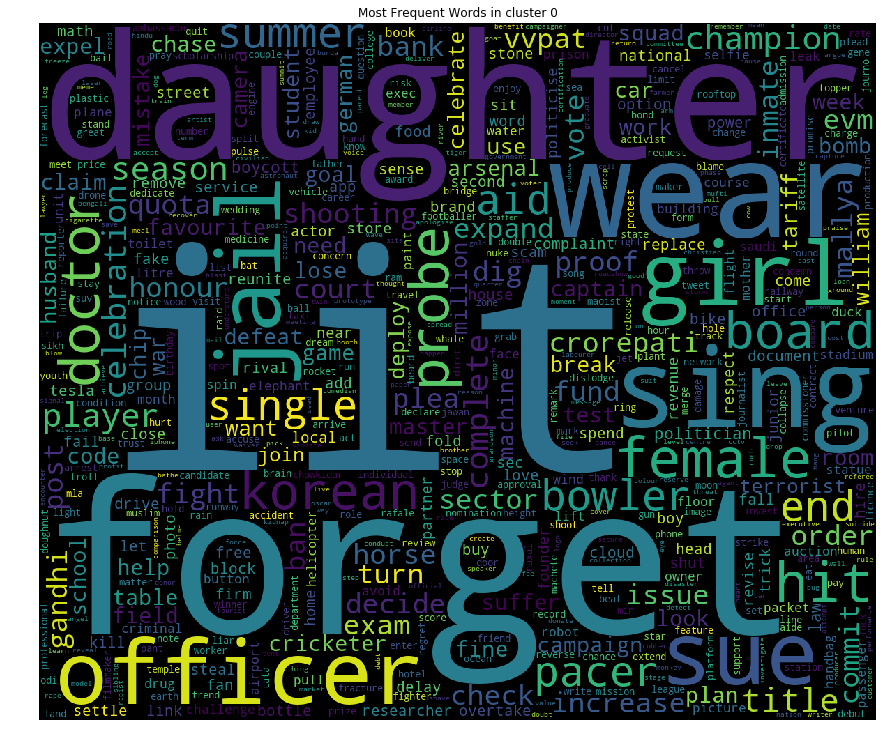

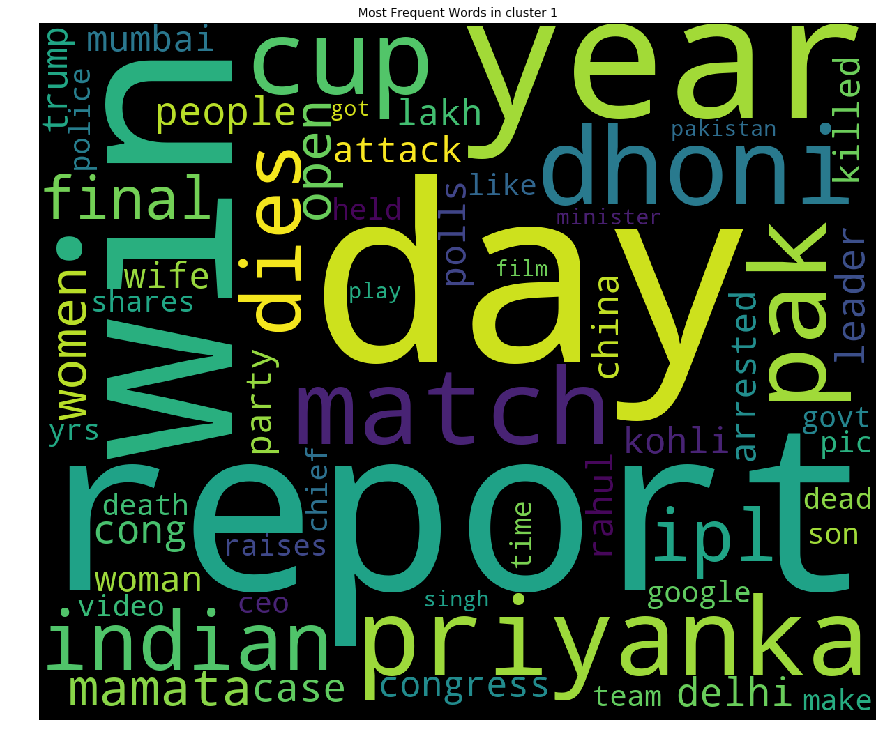

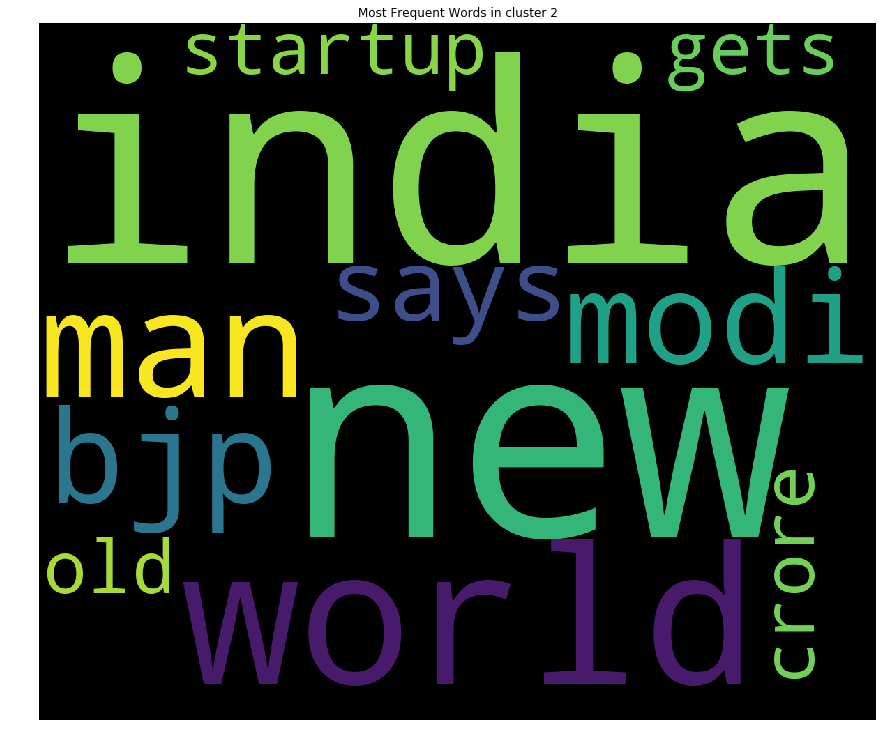

In [27]:
n = len(set(set(h_clusters)))
for i in range(n):
    arr = []
    for j, w in enumerate(word_list):
        if y_pred[j] == i+1:
            arr.append(w)
    buildWordCloud(i, ' '.join(arr))